In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from prophet import Prophet

# Indlæsning af data

In [19]:
sf_data         = pd.read_csv("../data/sf_data.csv", delimiter=";")
sf_districts    = pd.read_csv("../data/sf_districts.csv", delimiter=";")
sf_data_joined  = sf_data.merge(sf_districts, on='id')

# Dataformatering

In [20]:
crime          = sf_data_joined.copy()
crime["date"]  = pd.to_datetime(crime["date"], format="%m/%d/%Y")

In [21]:
crime_filtered = crime.query('category == "drug/narcotic"') # afgrænsning
crime_ts       = crime_filtered.groupby("date", as_index=False).size() # tæl daglige narko-sager
crime_ts       = crime_ts.rename(columns={"date": "ds", "size": "y"}) # formater til Prophet-format

# Tidsserieanalyse med Prophet (quick and dirty)

Opdel data i træning og test (30 datoer)

In [22]:
train_data, test_data = crime_ts[:-30], crime_ts[-30:]


In [23]:
train_data.tail() # cutoff dato er 2018-04-09

,ds,y
5498,2018-04-05,11
5499,2018-04-06,1
5500,2018-04-07,6
5501,2018-04-08,1
5502,2018-04-09,4


Fitter en model til al data

In [24]:
m = Prophet(daily_seasonality=False) # ny modelinstans 
m.fit(train_data) # træn data på model

Brug modellen til at forecaste perioden

In [25]:
future = m.make_future_dataframe(periods=36) # 6 datoer er tomme
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
5534,2018-05-11,2.883692,-5.450429,10.103921
5535,2018-05-12,1.561427,-6.381582,9.252567
5536,2018-05-13,0.846349,-6.452084,8.589781
5537,2018-05-14,4.293757,-3.326820,12.688660
5538,2018-05-15,5.936281,-1.969235,13.804981


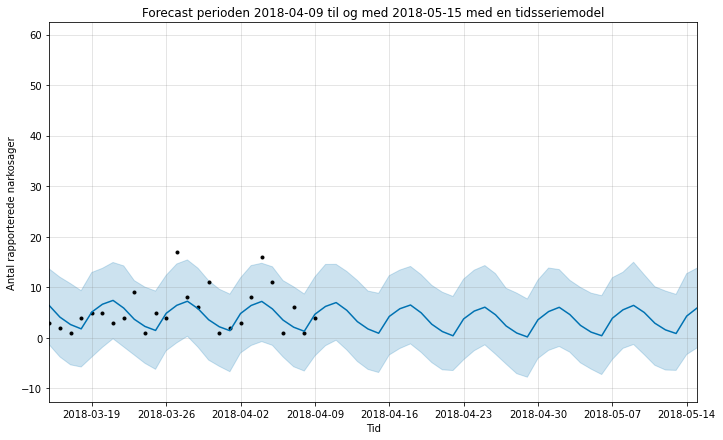

In [26]:
fig1 = m.plot(forecast)
plt.xlabel("Tid")
plt.ylabel("Antal rapporterede narkosager");
plt.title("Forecast perioden 2018-04-09 til og med 2018-05-15 med en tidsseriemodel")
plt.xlim(datetime(2018,3,15), datetime(2018,5,15));

In [27]:
forecast_data  = forecast.merge(test_data, on="ds", how="left")
forecast_data  = forecast_data[["ds", "y", "yhat"]] # udvælger kolonner
forecast_data  = forecast_data[forecast_data["ds"] > datetime(2018,4,9)] # udvælger rækker
forecast_data  = forecast_data.fillna(0) # erstatter na med 0

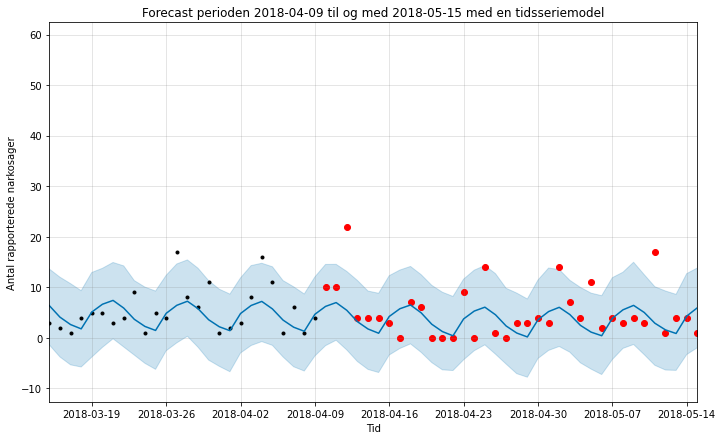

In [28]:
fig2 = m.plot(forecast)
plt.xlabel("Tid")
plt.ylabel("Antal rapporterede narkosager");
plt.xlim(datetime(2018,3,15), datetime(2018,5,15))
plt.title("Forecast perioden 2018-04-09 til og med 2018-05-15 med en tidsseriemodel")
plt.scatter(forecast_data["ds"], forecast_data["y"], color="red");

Der er noget systematisk der ikke er taget højde for

# Modelevaluering

In [29]:
# Udregner MSE (kunne også have brugt sklearn)
np.mean((forecast_data["y"] - forecast_data["yhat"]) ** 2)

25.957300574956616

In [30]:
# Udregner MAE (kunne også have brugt sklearn)
np.mean(np.abs(forecast_data["y"] - forecast_data["yhat"]))

3.5521445674943997

In [31]:
# Total antal narkosager i forecasting perioden
sum(forecast_data["y"])

186.0

Prophet laver automatisk decomposition af tidsserie med 3 komponenter
 - trend
 - seasonality
 - holidays
 
så
 y(t)=g(t)+s(t)+h(t)
 
Dette kan ses i deres dokumentation

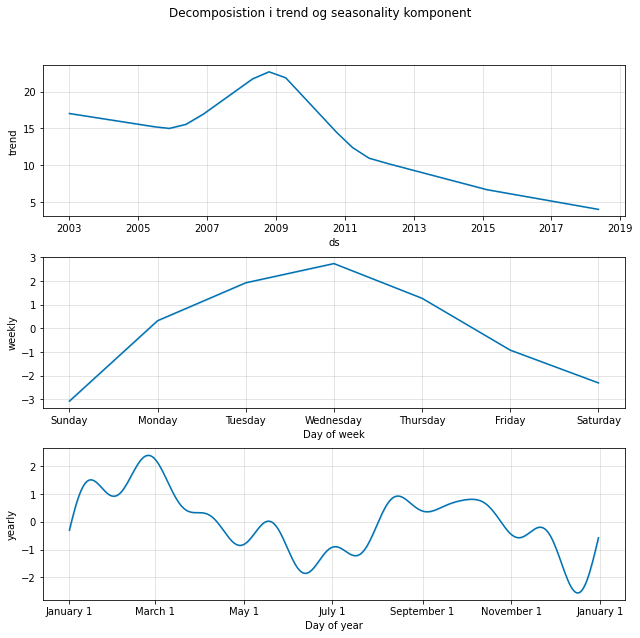

In [32]:
fig3 = m.plot_components(forecast)
fig3.subplots_adjust(top=0.89)
fig3.suptitle("Decomposistion i trend og seasonality komponent");